**Before you start**<br>Change runtime type to GPU<br>
Runtime > Change runtime type > GPU > Save

Google Drives links to data

test image
1U9_vgtPpmvKF6T3ePrvujuFCCciw1kED

training data
1daS9hza6ZZS_rv3Bg0N5EeQRfojbGANz

In [ ]:
# install fastai, this is a deep learning library
!pip install -Uqq fastbook
from fastai.vision.all import *
# this will make sure plots are printed as expected
%matplotlib inline
# check you have a GPU
torch.cuda.get_device_name(0)

     |████████████████████████████████| 720 kB 12.2 MB/s 
     |████████████████████████████████| 1.2 MB 38.3 MB/s 
     |████████████████████████████████| 189 kB 46.9 MB/s 
     |████████████████████████████████| 46 kB 3.5 MB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 
     |████████████████████████████████| 51 kB 320 kB/s 


'Tesla K80'

In [ ]:
# this will download a zip file containing training data
!gdown --id 15ARHV-oOLPqEiVDsNxKIAcCoFqTXca6s
# this will unzip the training data file
!unzip -qq /content/training\ data.zip
# go check it out in the folder view on the left

Downloading...
From: https://drive.google.com/uc?id=15ARHV-oOLPqEiVDsNxKIAcCoFqTXca6s
To: /content/training data.zip
100% 11.1M/11.1M [00:00<00:00, 30.5MB/s]


In [ ]:
# we are setting the path variable to the training data location
path = Path("/content/training data")
path_lbl = path/'500 tile masks'
path_img = path/'500 tiles'

# set the model name and version
model_base_name = 'road_model'
version = '1.0'

In [ ]:
# check the training files
print(len(path_lbl.ls(file_exts='.tif')))
verify_images(path_lbl.ls(file_exts='.tif'))

500


(#0) []

In [ ]:
print(len(path_img.ls(file_exts='.tif')))
verify_images(path_img.ls(file_exts='.tif'))

500


(#0) []

In [ ]:
# set the classes
codes = ['background','road']
print(len(codes))

2


In [ ]:
# save the classes to disk
np.savetxt(path/'codes.txt',codes,fmt='%s')

In [ ]:
# set some model variables
img_size_for_model = 200
batch_size = 10
model_type = resnet18

In [ ]:
# grad the input files as a list
fnames = get_image_files(path_img)
fnames[0]

Path('/content/training data/500 tiles/part_2825_Kojonup clip.tif')

In [ ]:
# define func to find mask files from images files
def label_func(file_path): 
    file_name = os.path.basename(file_path)
    label_path = os.path.join(path_lbl,file_name)
    return label_path

In [ ]:
# set up some image augmentations
item_tfms = [Resize(img_size_for_model)]
batch_tfms = [Normalize.from_stats(*imagenet_stats),
            *aug_transforms(size=img_size_for_model, flip_vert=True,max_rotate=90.0,max_lighting=0.1,
                            min_zoom=0.8, max_zoom=1.3, max_warp=0, 
                            
                            )]

In [ ]:
# load images into dataloader
dls = SegmentationDataLoaders.from_label_func(
    path, valid_pct=0.2, bs=batch_size, fnames = fnames, label_func = label_func, codes = codes,seed=42,
    item_tfms=item_tfms,batch_tfms=batch_tfms
)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [ ]:
# check the dataloader
dls.valid.items[:10]

[Path('/content/training data/500 tiles/part_23600_Kojonup clip.tif'),
 Path('/content/training data/500 tiles/part_25125_Kojonup clip.tif'),
 Path('/content/training data/500 tiles/part_11144_Kojonup clip.tif'),
 Path('/content/training data/500 tiles/part_23467_Kojonup clip.tif'),
 Path('/content/training data/500 tiles/part_4704_Kojonup clip.tif'),
 Path('/content/training data/500 tiles/part_4636_Kojonup clip.tif'),
 Path('/content/training data/500 tiles/part_2176_Kojonup clip.tif'),
 Path('/content/training data/500 tiles/part_10233_Kojonup clip.tif'),
 Path('/content/training data/500 tiles/part_26066_Kojonup clip.tif'),
 Path('/content/training data/500 tiles/part_4561_Kojonup clip.tif')]

In [ ]:
# check the dataloader
len(dls.train_ds.items)

400

In [ ]:
# check the dataloader
len(dls.valid.items)

100

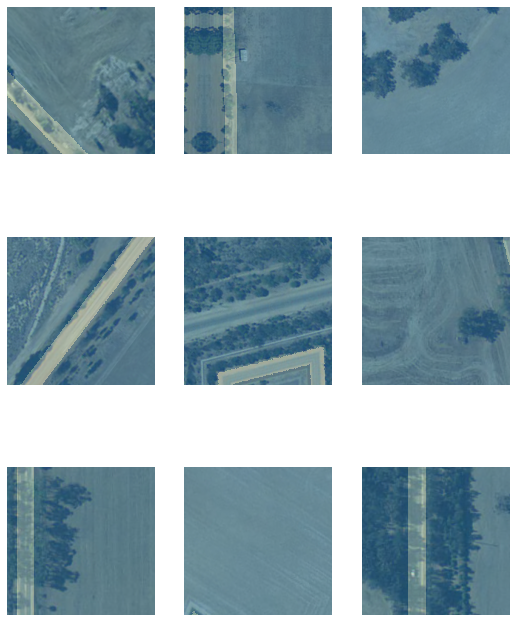

In [ ]:
# show some files with masks
dls.show_batch(vmin=0, vmax=len(codes)-1, figsize=(9,12))

In [ ]:
# setup model
learn = unet_learner(dls, model_type,self_attention=True,act_cls=Mish,opt_func=ranger)#.to_fp16()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
# make names for models
big_model_base = model_base_name+'_v'+version+'_base'
big_model_ft = model_base_name+'_v'+version+'_ft'
print(big_model_base)
print(big_model_ft)

road_model_v1.0_base
road_model_v1.0_ft


epoch,train_loss,valid_loss,time
0,0.316703,0.192114,00:43
1,0.225919,0.169984,00:34
2,0.189454,0.152120,00:34


Better model found at epoch 0 with valid_loss value: 0.1921137571334839.


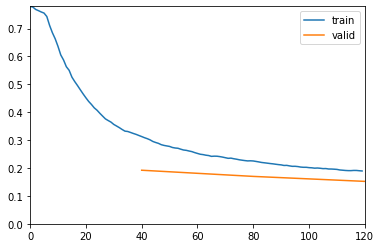

Better model found at epoch 1 with valid_loss value: 0.16998374462127686.
Better model found at epoch 2 with valid_loss value: 0.15211978554725647.


In [ ]:
# start training
ranger_lr = 1e-3
learn.fit_flat_cos(3,slice(ranger_lr),cbs = [ShowGraphCallback(),
                                          SaveModelCallback(monitor='valid_loss',comp = np.less,with_opt=True, 
                                                            fname=big_model_base)])

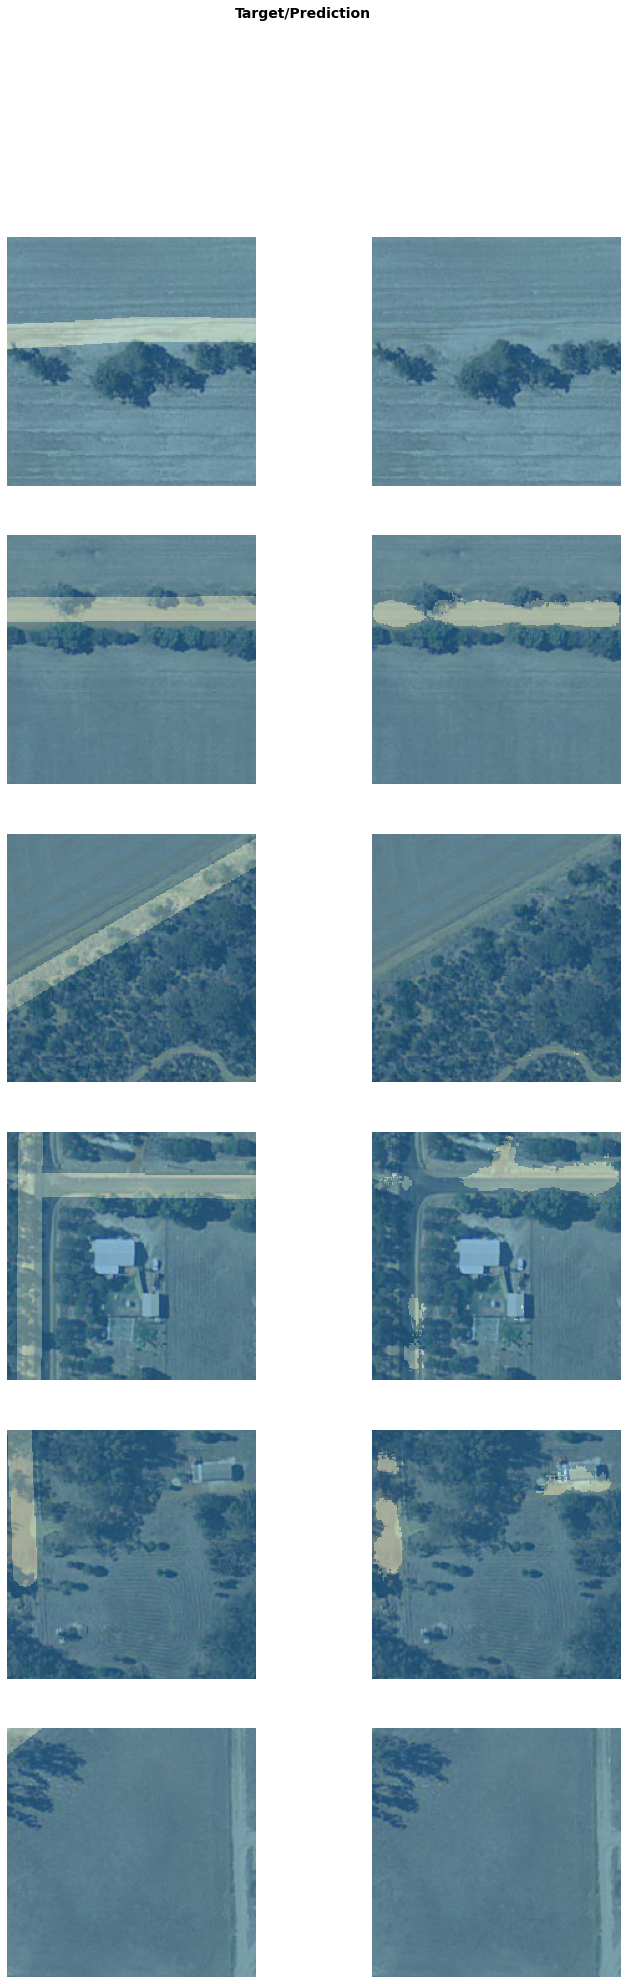

In [ ]:
# reload best model and display some outputs
learn.load(big_model_base)
learn.show_results(max_n=6, figsize=(12,32),vmin=0, vmax=len(codes)-1)

In [ ]:
# set lr for next model run
ranger_lrs = slice(ranger_lr/400, ranger_lr/4)
ranger_lr, ranger_lrs

(0.001, slice(2.5e-06, 0.00025, None))

epoch,train_loss,valid_loss,time
0,0.161870,0.153700,00:35
1,0.160019,0.151321,00:35
2,0.156504,0.146858,00:35
3,0.155536,0.144962,00:35
4,0.152291,0.140082,00:35


Better model found at epoch 0 with valid_loss value: 0.1536996215581894.


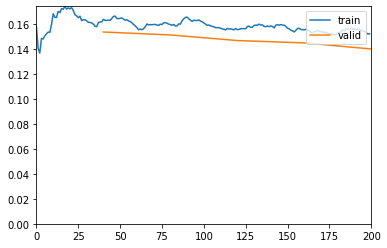

Better model found at epoch 1 with valid_loss value: 0.15132136642932892.
Better model found at epoch 2 with valid_loss value: 0.14685766398906708.
Better model found at epoch 3 with valid_loss value: 0.14496174454689026.
Better model found at epoch 4 with valid_loss value: 0.14008192718029022.


In [ ]:
# continue training model unfrozen
learn.unfreeze()
learn.fit_flat_cos(5, ranger_lrs, cbs = [ShowGraphCallback(),
                                          SaveModelCallback(monitor='valid_loss',comp = np.less,with_opt=True, 
                                                            fname=big_model_ft)])

In [ ]:
# reload best model
learn.load(big_model_ft)

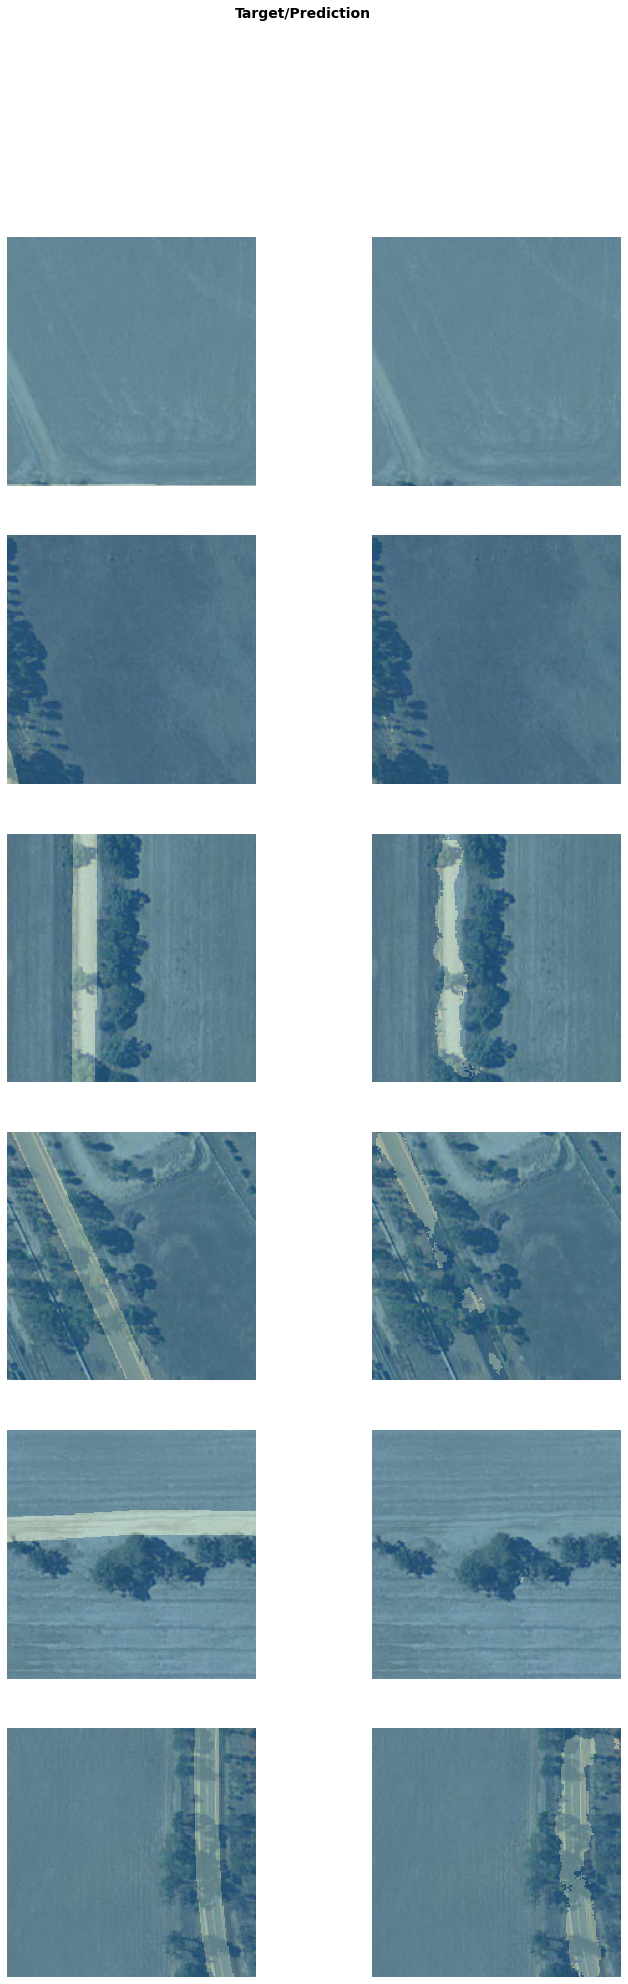

In [ ]:
# display some examples
learn.show_results(max_n=6, figsize=(12,32),vmin=0, vmax=len(codes)-1)

In [ ]:
# save best model to disk
export_path = 'models/'+big_model_ft+'.pkl'
print(export_path)
learn.export(export_path)

models/road_model_v1.0_ft.pkl


In [ ]:
# dowload some imagery to test the model on
!gdown --id 13y4iyauHGWo6pqdNdx_hSQRh3t1QpLOs

Downloading...
From: https://drive.google.com/uc?id=13y4iyauHGWo6pqdNdx_hSQRh3t1QpLOs
To: /content/test area.tif
100% 34.0M/34.0M [00:00<00:00, 35.1MB/s]


In [ ]:
# install rasterio for GIS raster operations
!pip install rasterio

     |████████████████████████████████| 19.3 MB 1.3 MB/s 


In [ ]:
# import some more libraries 
import os
import rasterio
from tqdm.auto import tqdm
from pathlib import Path

In [ ]:
# set raster path variable
raster_path = '/content/test area.tif'
raster_file = os.path.basename(raster_path)
os.path.isfile(raster_path)

True

In [ ]:
# make folder for tiles
output_folder = '/content/test tiles'
Path(output_folder).mkdir(parents=True, exist_ok=True)

In [ ]:
# set info for tiling loop
size = [200,200] #[x,y]
output_compression = 'JPEG'#'lZW'
output_format = 'GTiff'

In [ ]:
# open input raster and grab metadata
with rasterio.open(raster_path) as open_raster:
    input_meta = open_raster.meta
input_meta

{'count': 4,
 'crs': CRS.from_epsg(28350),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 7796,
 'nodata': None,
 'transform': Affine(0.4999928301530382, 0.0, 536087.801,
       0.0, -0.5000214340687782, 6278654.8954),
 'width': 10586}

In [ ]:
# make a list of tiles by looping over raster height and width
tiles = []
left = 0
tile_count = 0
while left < input_meta['width']:
    top=0
    while top < input_meta['height']:
        tile_count += 1
        name = 'part_'+str(tile_count)+'_'+raster_file
        export_path = os.path.join(output_folder,name)
        
        tiles.append([left,top,export_path])
        top += size[1]
    left += size[0]
print(len(tiles))
tiles[0]

2067


[0, 0, '/content/test tiles/part_1_test area.tif']

In [ ]:
# cut out each tile from list
with rasterio.open(raster_path) as src:
  for tile in tqdm(tiles):
    if not os.path.isfile(tile[2]):
        win = rasterio.windows.Window(tile[0], tile[1], size[0], size[1])
        win_data = src.read(window=win)
        win_transform = src.window_transform(win)
        meta = src.meta
        meta['compress'] = output_compression
        meta['driver'] = output_format
        meta['transform'] = win_transform
        meta['width'] = win_data.shape[2]
        meta['height'] = win_data.shape[1]
        with rasterio.open(tile[2], 'w', **meta) as dst:
            dst.write(win_data)
        win_data = None

  0%|          | 0/2067 [00:00<?, ?it/s]

In [ ]:
# get a list of tiles
all_tiles = Path(output_folder).ls()
len(all_tiles)

2067

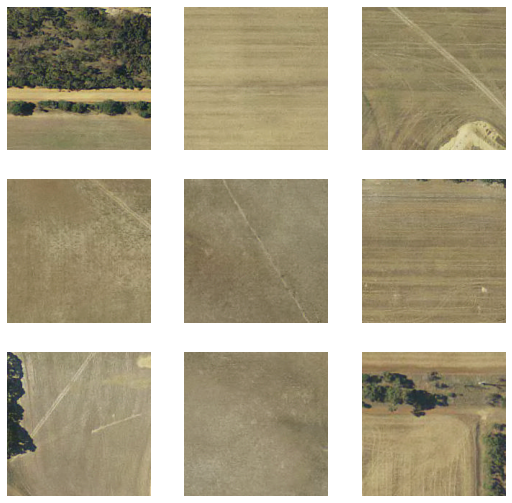

In [ ]:
# load images into data loader and push onto GPU
dl = learn.dls.test_dl(all_tiles,device='cuda',bs=batch_size)
dl.show_batch()

In [ ]:
# run model over images
preds = learn.get_preds(dl=dl,with_decoded=True)

In [ ]:
image_with_road = 50
all_tiles[image_with_road]

Path('/content/test tiles/part_1092_test area.tif')

In [ ]:
# preds[0][image_with_road].detach().cpu().numpy()[0].shape

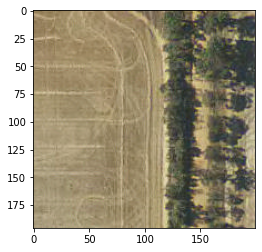

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(all_tiles[image_with_road])
plt.imshow(img)

In [ ]:
# push pred from GPU tensor to numpy
test_pred_np = preds[0][image_with_road].detach().cpu().numpy()
test_pred_np.shape

(2, 200, 200)

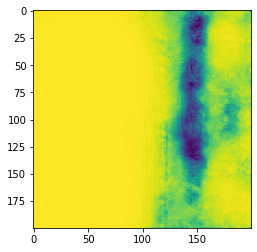

In [ ]:
# plot up background class
plt.imshow(test_pred_np[0])

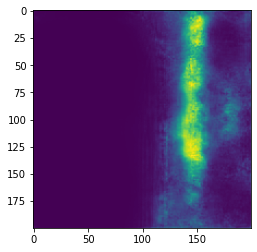

In [ ]:
# plot up road class
plt.imshow(test_pred_np[1])

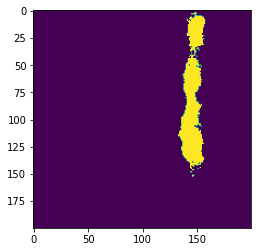

In [ ]:
# argmax them
plt.imshow(np.argmax(test_pred_np,0))

In [ ]:
# make folder for predictions
preds_folder = '/content/pred tiles'
Path(preds_folder).mkdir(parents=True, exist_ok=True)

In [ ]:
# loop over preditions and save them to disk using images metadata
pred_files = []
for pred,path in tqdm(zip(preds[0],all_tiles),total = len(all_tiles)):

  pred_max_np = np.argmax(pred.detach().cpu().numpy(),0)
  
  file_name = os.path.basename(path) 
  export_path = os.path.join(preds_folder,file_name)
  pred_files.append(export_path)

  with rasterio.open(path) as base_img:
    meta = base_img.meta
    meta['count'] = 1
    meta['compress'] = 'LZW'   

    with rasterio.open(export_path, 'w', **meta) as dst:
        dst.write(pred_max_np.astype(rasterio.uint8), 1)

  0%|          | 0/2067 [00:00<?, ?it/s]

In [ ]:
# open each prediction file and add add it to a list
src_mosaic = []
for i in tqdm(pred_files):
  src = rasterio.open(i)
  src_mosaic.append(src)

  0%|          | 0/2067 [00:00<?, ?it/s]

In [ ]:
# merge the predictions together
from rasterio.merge import merge
mosaic, out_trans = merge(src_mosaic)

In [ ]:
# copy metadata and update it for our larger raster
out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 "compress": 'LZW' 
                 }
                )

In [ ]:
# export out prediction raster
with rasterio.open('/content/pred.tif', "w", **out_meta) as dest:
  dest.write(mosaic)